# Modelo de clasificación de Alopecia androgénica

Origen del dataset: hair-loss Classification Model by uze (2024). https://universe.roboflow.com/uze/hair-loss-nq8hh/dataset/1#.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
from PIL import Image
import copy
from sklearn.metrics import classification_report, confusion_matrix

import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from ema_pytorch import EMA
from torchvision.models import maxvit_t, MaxVit_T_Weights
from torch import autocast, GradScaler
import kornia.augmentation as K

## Import and Explore Data

In [ ]:
# Load CSV files
df_train = pd.read_csv('data/train/_classes.csv')
df_val = pd.read_csv('data/valid/_classes.csv')
df_test = pd.read_csv('data/test/_classes.csv')

df_train.head()

,filename,LEVEL_2,LEVEL_3,LEVEL_4,LEVEL_5,LEVEL_6,LEVEL_7
0,6-Top-Down_jpg.rf.4252cf8d3e687a40911d8b5f9da5...,0,0,0,0,0,1
1,21-Top-Down_jpg.rf.f734ee6ad56c1c2ef52282075ba...,0,0,1,0,0,0
2,29-Left_jpg.rf.135d5af193e222e625aabea88f4180a...,0,1,0,0,0,0
3,2-Left_jpg.rf.87838472392bb67c2b54b51a290891b0...,0,0,0,0,1,0
4,9-Back_jpg.rf.46221e6415c7b920153e6ba0980d503d...,1,0,0,0,0,0


In [ ]:
# Check dataframes info
df_train.info()
df_val.info()
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1294 entries, 0 to 1293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  1294 non-null   object
 1    LEVEL_2  1294 non-null   int64 
 2    LEVEL_3  1294 non-null   int64 
 3    LEVEL_4  1294 non-null   int64 
 4    LEVEL_5  1294 non-null   int64 
 5    LEVEL_6  1294 non-null   int64 
 6    LEVEL_7  1294 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 70.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133 entries, 0 to 132
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  133 non-null    object
 1    LEVEL_2  133 non-null    int64 
 2    LEVEL_3  133 non-null    int64 
 3    LEVEL_4  133 non-null    int64 
 4    LEVEL_5  133 non-null    int64 
 5    LEVEL_6  133 non-null    int64 
 6    LEVEL_7  133 non-null    int64 
dtypes: int64(6), object(1)
memory usage: 7.4+ KB
<clas

In [ ]:
# Check for missing values
print(df_train.isnull().sum().sum())
print(df_val.isnull().sum().sum())
print(df_test.isnull().sum().sum())

0
0
0


**Findings**  
None of the three datasets contain any null values.

### Visualizations

#### Class visualization

In [ ]:
def plot_value_counts(df, column, ax_num, title):
    """
    Plots the value counts of a specified column in a DataFrame.
    """
    cols = df.columns.tolist()
    cols.remove(column)

    counts = df[cols].sum()
    sns.barplot(x=counts.index, y=counts.values, palette='terrain', hue=counts.index, ax=ax_num)
    ax_num.set_xlabel(column)
    ax_num.set_ylabel('Count')
    ax_num.set_title(title)

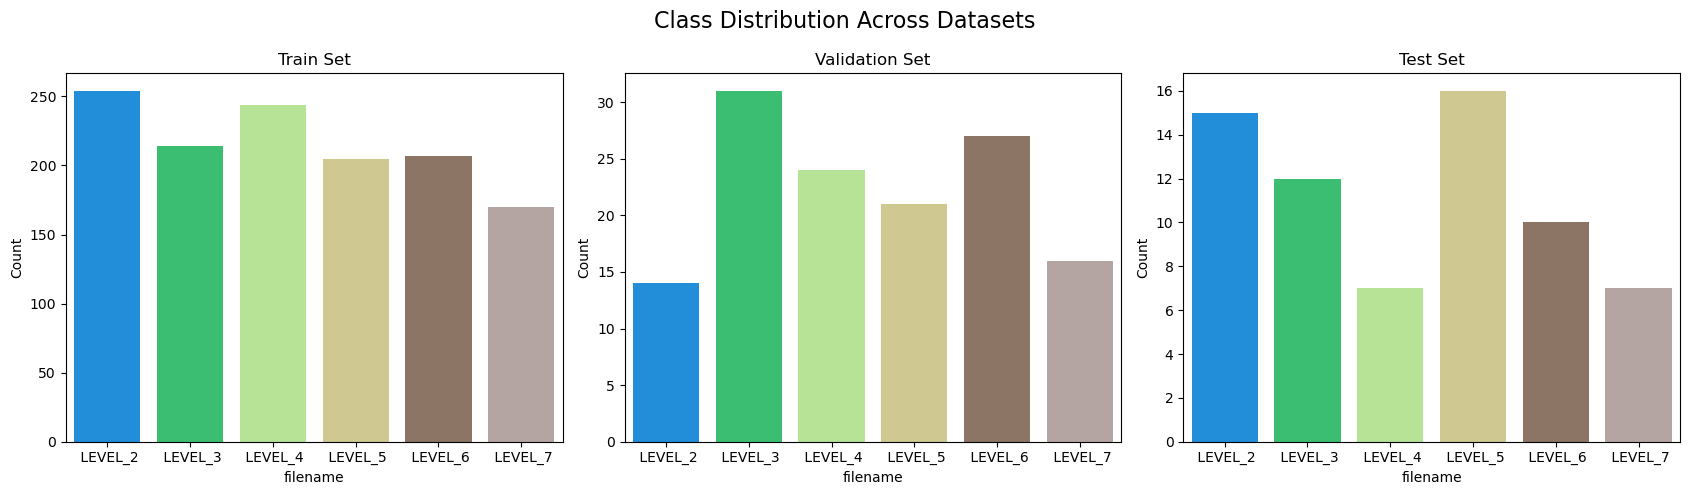

In [ ]:
# Plot class distributions for train, validation, and test sets
fig, ax = plt.subplot_mosaic(
    mosaic=[[0, 1, 2]],
    figsize=(17, 5)
)
plot_value_counts(df_train, 'filename', ax[0], 'Train Set')
plot_value_counts(df_val, 'filename', ax[1], 'Validation Set')
plot_value_counts(df_test, 'filename', ax[2], 'Test Set')
plt.suptitle('Class Distribution Across Datasets', fontsize=16)
plt.tight_layout()
plt.show()

**Findings**  
While the train set has balanced labels, both validation and test set don't, having the most common class more than twice the size of the rarest.

#### Image visualization

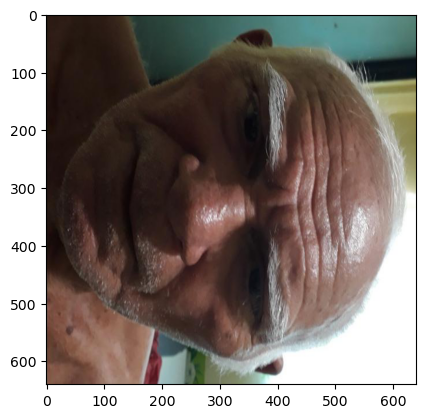

In [ ]:
# Display a random image from the training set
rand_num = np.random.randint(len(df_train))
img = Image.open("data/train/" + df_train["filename"][rand_num])
plt.imshow(img);

**Findings**  
Images from the training set had already been augmented by fliping them both horizontally and vertically

## Data processing

In [ ]:
def undo_one_hot_encoding(df):
    """
    Transforms one-hot encoded labels into 0-1 scale levels.
    """
    # Create a new DataFrame to store the results and not mess up the original one
    df_undo = df[['filename']].copy()
    label_columns = df.columns.tolist()
    label_columns.remove('filename')
    # Find the index of the maximum value in each row and extract the level number
    df_undo['level'] = df[label_columns].idxmax(axis=1).str.extract('(\d)').astype(int) - 2
    df_undo['level'] = df_undo['level'] / 5

    return df_undo

df_train= undo_one_hot_encoding(df_train)
df_val = undo_one_hot_encoding(df_val)
df_test = undo_one_hot_encoding(df_test)

df_train.level.unique()

array([1. , 0.4, 0.2, 0.8, 0. , 0.6])

In [190]:
# Transforms images from 640x640 to 224x224 tensors
to_tensor = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [ ]:
# Creates a tensor stacking all training resized images
X_train_tensor = torch.stack([to_tensor(Image.open(f'data/train/{fname}')) for fname in df_train["filename"]]).squeeze()

# The extra dimension is needed for the loss function when training the model
y_train_tensor = torch.tensor(df_train['level'], dtype=torch.float32).unsqueeze(1)
X_train_tensor.size(), y_train_tensor.size()

(torch.Size([1294, 3, 224, 224]), torch.Size([1294, 1]))

In [31]:
X_val_tensor = torch.stack([to_tensor(Image.open(f'data/valid/{fname}')).squeeze() for fname in df_val["filename"]])
y_val_tensor = torch.tensor(df_val['level'], dtype=torch.float32).unsqueeze(1)
X_val_tensor.size(), y_val_tensor.size()

(torch.Size([133, 3, 224, 224]), torch.Size([133, 1]))

In [32]:
X_test_tensor = torch.stack([to_tensor(Image.open(f'data/test/{fname}')).squeeze() for fname in df_test["filename"]])
y_test_tensor = torch.tensor(df_test['level'], dtype=torch.float32).unsqueeze(1)
X_test_tensor.size(), y_test_tensor.size()

(torch.Size([67, 3, 224, 224]), torch.Size([67, 1]))

In [ ]:
# Save processed tensors
torch.save(X_train_tensor, 'data/train/X_train_data.pt')
torch.save(y_train_tensor, 'data/train/y_train_data.pt')
torch.save(X_val_tensor, 'data/valid/X_val_data.pt')
torch.save(y_val_tensor, 'data/valid/y_val_data.pt')
torch.save(X_test_tensor, 'data/test/X_test_data.pt')
torch.save(y_test_tensor, 'data/test/y_test_data.pt')

In [ ]:
# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [ ]:
# Load tensors for training
X_train_tensor = torch.load('data/train/X_train_data.pt')
y_train_tensor = torch.load('data/train/y_train_data.pt')
X_val_tensor = torch.load('data/valid/X_val_data.pt')
y_val_tensor = torch.load('data/valid/y_val_data.pt')

X_train_tensor.shape, y_train_tensor.shape, X_val_tensor.shape, y_val_tensor.shape

(torch.Size([1294, 3, 224, 224]),
 torch.Size([1294, 1]),
 torch.Size([133, 3, 224, 224]),
 torch.Size([133, 1]))

In [ ]:
# Create tensor dataset for data loader
Train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

Train_dataset[:][0].shape, Train_dataset[:][1].shape

(torch.Size([1294, 3, 224, 224]), torch.Size([1294, 1]))

In [114]:
Train_dataset[:5][1]

tensor([[1.0000],
        [0.4000],
        [0.2000],
        [0.8000],
        [0.0000]])

### Data Augmentation

Data augmentation pipeline for training images.  
Includes random rotations, resized crops, equalization, saturation, hue, contrast, brightness adjustments,
and normalization to improve model generalization.

In [ ]:
augment_train = torch.nn.Sequential(
    K.RandomRotation(degrees=(-22.5, 22.5), p=0.5),
    K.RandomResizedCrop(size=(224, 224), scale=(0.9, 1.1), ratio=(0.9, 1.1), p=0.5),
    K.RandomEqualize(p=0.5),
    #K.RandomGaussianNoise(mean=0, std=0.075, p=0.5),
    K.RandomSaturation(saturation=(0.75, 1.25), p=0.5),
    K.RandomHue(hue=(-0.075, 0.075), p=0.5),
    K.RandomContrast(contrast=(0.8, 1.2), p=0.5),
    K.RandomBrightness(brightness=(0.8, 1.1), p=0.5),
    #K.RandomElasticTransform(p=0.5),
    #K.RandomPerspective(distortion_scale=0.2, p=0.5),
    K.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

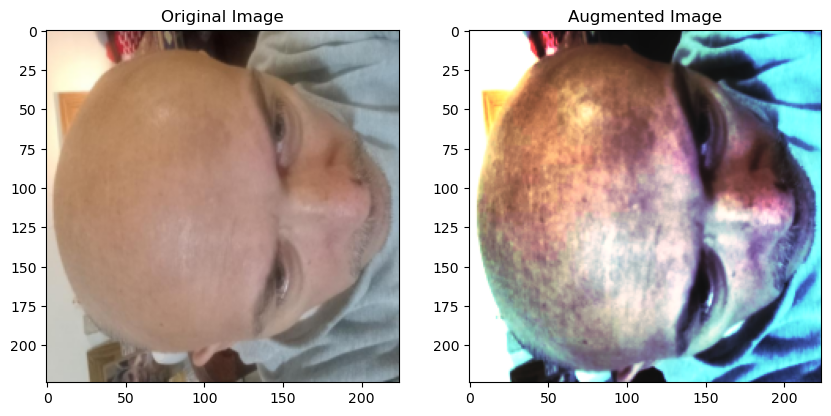

In [ ]:
# Sample a random image from the training dataset and apply augmentation
rand_num = np.random.randint(len(Train_dataset))
img = Train_dataset[rand_num][0]
img_aug = augment_train(img)

# Remove batch dimension
img_aug = img_aug.squeeze()

# Denormalize for visualization
denormalize = K.Denormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
img_aug_denorm = denormalize(img_aug)

# Permute dimensions for visualization
img_aug_permuted = img_aug_denorm[0].permute(1, 2, 0).numpy()
img_permuted = img.permute(1, 2, 0).numpy()  

# Clip values to [0, 1] range for proper display
img_aug_cliped = np.clip(img_aug_permuted, 0, 1)
img_cliped = np.clip(img_permuted, 0, 1)

# Display original and augmented images side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_cliped)
ax[1].imshow(img_aug_cliped)
ax[0].set_title('Original Image')
ax[1].set_title('Augmented Image')

plt.show()


## Model Architecture & Initialization

In [ ]:
def build_maxvit_t():
    """Builds a customized version of the MaxViT-T model for regression tasks."""
    weights = MaxVit_T_Weights.IMAGENET1K_V1
    model = maxvit_t(weights=weights)
    
    # Freeze the parameters of the first block
    for param in model.blocks[0].parameters():
        param.requires_grad = False
    
    # Set dropout rate to 0.5 in all Dropout layers except the first block which is frozen
    for module in model.blocks[1:].modules():
        if isinstance(module, nn.Dropout):
            module.p = 0.5         

    # Modify the final layer to output a single value for regression
    in_features = model.classifier[-1].in_features # 512
    model.classifier[-1] = nn.Linear(in_features, 1)

    return model

In [ ]:
Model = build_maxvit_t()

## Model Training

In [181]:
def train_model(model, train_dataset, X_tensor_val, y_tensor_val, epochs=500, batch_size=64, learning_rate=5e-5, scheduler=False, scheduler_patience=50, early_stopping=True, early_stopping_patience=100, smooth=True, show=True):
    """
    Trains the model with the training data.
    
    Parameters:
    - model (nn.Module): Model instance.
    - train_dataset (TensorDataset): Training dataset.
    - X_tensor_val (Tensor): Validation feature tensor.
    - y_tensor_val (Tensor): Validation label tensor.
    - epochs (int): Number of training epochs.
    - batch_size (int): Batch size for training.
    - learning_rate (float): Learning rate for the optimizer.
    - scheduler (bool): Whether to use a learning rate scheduler.
    - scheduler_patience (int): Number of epochs to wait before reducing the learning rate.
    - early_stopping (bool): Whether to use early stopping.
    - early_stopping_patience (int): Number of epochs to wait before stopping training.
    - smooth (bool): Whether to use smoothing the model weights with EMA.
    - show (bool): Whether to display training messages.

    Returns:
    - model (nn.Module): Trained model.
    """
    torch.manual_seed(27)
    
    model = model.to(device)
    if early_stopping:
        X_tensor_val = X_tensor_val.to(device)
        y_tensor_val = y_tensor_val.to(device)

    optimizer = optim.AdamW(
        model.parameters(),
        lr=learning_rate,
        weight_decay=1e-8            
    )

    criterion = nn.L1Loss()

    scaler = GradScaler()

    if smooth:
        ema = EMA(
            model,
            beta=0.9999,
            update_after_step=0,
            update_every=1
        )

    if scheduler:
        step_lr = optim.lr_scheduler.StepLR(optimizer, 
                                            step_size=scheduler_patience, 
                                            gamma=0.85)

    if early_stopping:
        best_val_loss = float('inf')
        epochs_without_improvement = 0
        best_model = None

    generator = torch.Generator()
    generator.manual_seed(27)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        generator=generator,
        pin_memory=True
    )

    for epoch in range(epochs):

        if show:
            total_loss = 0.0

        model.train()
        for x_batch, y_batch in train_loader:
            x_batch = augment_train(x_batch)
            x_batch = x_batch.to(device, non_blocking=True)
            y_batch = y_batch.to(device, non_blocking=True)
            
            optimizer.zero_grad()

            with autocast(device_type=device.type):
                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)

            if show:
                total_loss += loss.item()
       
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            if smooth:
                ema.update()

        if scheduler:
            step_lr.step()

        model_eval = ema.ema_model if smooth else model

        if early_stopping:

            model_eval.eval()

            with torch.no_grad():
                X_tensor_val_augmented = augment_train(X_tensor_val)
                val_outputs = model_eval(X_tensor_val_augmented)
                val_loss = criterion(val_outputs, y_tensor_val)
           
            if val_loss.item() < best_val_loss:
                best_val_loss = val_loss.item()
                epochs_without_improvement = 0
                best_model = model_eval.state_dict()
            else:
                epochs_without_improvement += 1

                if epochs_without_improvement >= early_stopping_patience:
                    if show:
                        print(f'No improvement observed in {early_stopping_patience} epochs. Stopping training.')

                    model.load_state_dict(best_model)
                    return model

        if show and ((epoch + 1) % 2 == 0):
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {total_loss / len(train_loader):.4f}')
            if early_stopping:
                print(f'Best validation loss:{best_val_loss:.4f}')
                print(f'Current validation loss:{val_loss.item():.4f}')
                print("-" * 30)

    if early_stopping and best_model:
        model.load_state_dict(best_model)
    return model


In [124]:
print(torch.cuda.memory_allocated())

0


In [ ]:
Model = train_model(Model, Train_dataset, X_val_tensor, y_val_tensor)

Época [2/500], Pérdida: 0.2158
Mejor pérdida de validación:0.3046
Pérdida de validación actual:0.3046
------------------------------
Época [4/500], Pérdida: 0.1732
Mejor pérdida de validación:0.2659
Pérdida de validación actual:0.2679
------------------------------
Época [6/500], Pérdida: 0.1562
Mejor pérdida de validación:0.2178
Pérdida de validación actual:0.2178
------------------------------
Época [8/500], Pérdida: 0.1430
Mejor pérdida de validación:0.2029
Pérdida de validación actual:0.2073
------------------------------
Época [10/500], Pérdida: 0.1307
Mejor pérdida de validación:0.1787
Pérdida de validación actual:0.1787
------------------------------
Época [12/500], Pérdida: 0.1258
Mejor pérdida de validación:0.1591
Pérdida de validación actual:0.1591
------------------------------
Época [14/500], Pérdida: 0.1157
Mejor pérdida de validación:0.1505
Pérdida de validación actual:0.1528
------------------------------
Época [16/500], Pérdida: 0.1121
Mejor pérdida de validación:0.1334

In [ ]:
torch.save(Model.state_dict(), 'maxvit_t_model_state_dict.pth')

## Model Evaluation

In [175]:
Model = build_maxvit_t()
Model.load_state_dict(torch.load('maxvit_t_model_state_dict.pth'))
Model = Model.to(device)

In [176]:
def evaluate_model(y_eval, logits_pred):
    """Evaluates the model's predictions against the true labels and prints various metrics and visualizations."""

    # Formatting tensors to numpy arrays
    y_eval = y_eval.view(-1).detach().cpu().numpy()
    logits_pred = logits_pred.view(-1).detach().cpu().numpy()

    # Rescaling values back to original range and adding 1 to avoid division by zero in MAPE
    y_eval = y_eval * 5 + 1
    logits_pred = logits_pred * 5 + 1

    # Clipping values to be within [1, 6]
    logits_pred[logits_pred <  1] = 1
    logits_pred[logits_pred > 6] = 6

    # Rounding to nearest integer
    y_pred = np.round(logits_pred).astype(int)
    y_eval = np.round(y_eval).astype(int)

    # One-Hot Encoding
    y_pred_one_hot = pd.get_dummies(y_pred)
    y_eval_one_hot = pd.get_dummies(y_eval)
    
    # Assert that both have the same columns
    y_pred_one_hot = y_pred_one_hot.reindex(columns=[1, 2, 3, 4, 5, 6], fill_value=False)
    y_eval_one_hot = y_eval_one_hot.reindex(columns=[1, 2, 3, 4, 5, 6], fill_value=False)

    # Classification Report
    print(classification_report(y_eval_one_hot, y_pred_one_hot))
    print(f'Accuracy: {np.mean(y_pred == y_eval):.2f}')
    print(f"MAPE: {np.mean(np.abs(logits_pred - y_eval)) / np.mean(y_eval) * 100:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(y_eval, y_pred)
    error = y_eval - logits_pred
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='crest', ax=ax[0])
    ax[0].set_xlabel('Prediction')
    ax[0].set_ylabel('Real')
    ax[0].set_title('Confusion Matrix')

    sns.kdeplot(error, ax=ax[1], color='navy', fill=True)
    ax[1].axvline(x=error.mean(), color='red', linestyle='--')
    ax[1].set_title('Error Distribution')

    plt.show()


In [177]:
normalize = K.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

              precision    recall  f1-score   support

           0       0.85      0.73      0.79        15
           1       0.67      0.67      0.67        12
           2       0.60      0.86      0.71         7
           3       0.92      0.69      0.79        16
           4       0.67      0.80      0.73        10
           5       0.88      1.00      0.93         7

   micro avg       0.76      0.76      0.76        67
   macro avg       0.76      0.79      0.77        67
weighted avg       0.78      0.76      0.76        67
 samples avg       0.76      0.76      0.76        67

Accuracy: 0.76
MAPE: 8.59%


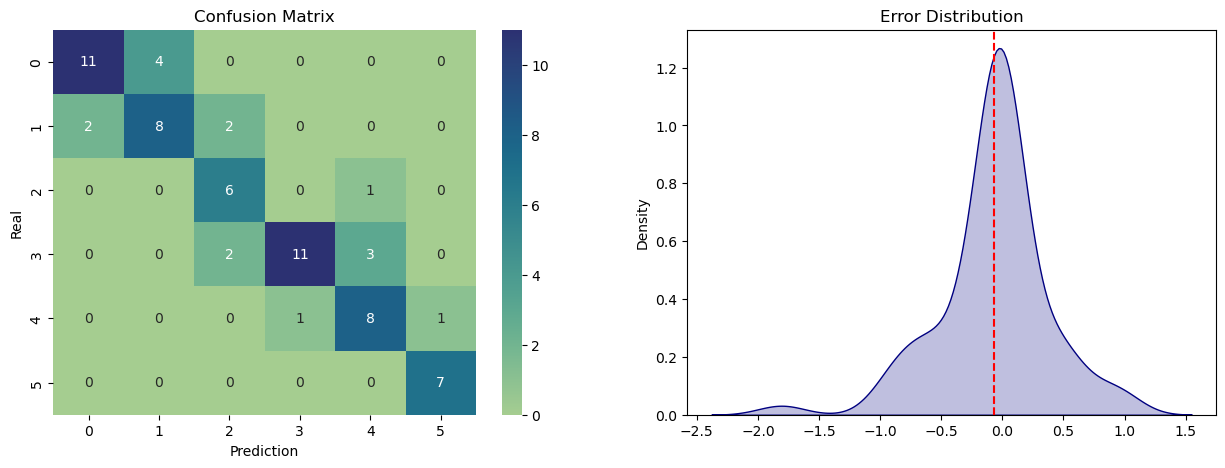

In [178]:
X_test_tensor = torch.load('data/test/X_test_data.pt').to(device)
y_test_tensor = torch.load('data/test/y_test_data.pt').to(device)

X_test_tensor = normalize(X_test_tensor)

with torch.inference_mode():
    Model.eval()
    logits_test = Model(X_test_tensor)

evaluate_model(y_eval=y_test_tensor, logits_pred=logits_test)
del X_test_tensor, y_test_tensor 
torch.cuda.empty_cache()

              precision    recall  f1-score   support

           0       0.80      0.86      0.83        14
           1       0.82      0.74      0.78        31
           2       0.71      0.71      0.71        24
           3       0.61      0.67      0.64        21
           4       0.82      0.85      0.84        27
           5       1.00      0.94      0.97        16

   micro avg       0.78      0.78      0.78       133
   macro avg       0.79      0.79      0.79       133
weighted avg       0.79      0.78      0.78       133
 samples avg       0.78      0.78      0.78       133

Accuracy: 0.78
MAPE: 9.04%


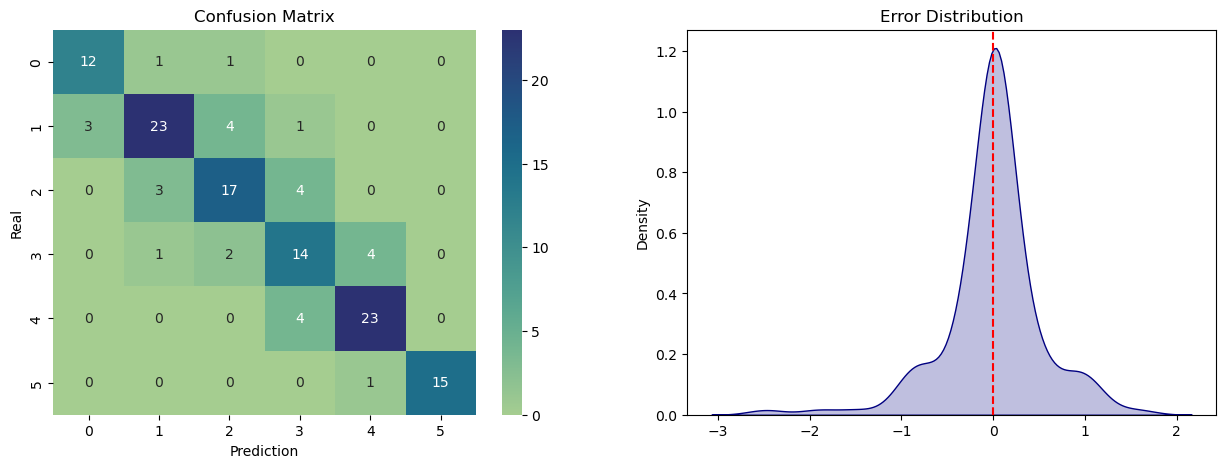

In [179]:
X_val_tensor = torch.load('data/valid/X_val_data.pt')
y_val_tensor = torch.load('data/valid/y_val_data.pt')
X_val_tensor = normalize(X_val_tensor)

X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)

with torch.inference_mode():
    Model.eval()
    logits = Model(X_val_tensor)
    
evaluate_model(y_eval=y_val_tensor, logits_pred=logits)

del X_val_tensor, y_val_tensor 
torch.cuda.empty_cache()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       254
           1       1.00      1.00      1.00       214
           2       1.00      1.00      1.00       244
           3       1.00      1.00      1.00       205
           4       1.00      1.00      1.00       207
           5       1.00      1.00      1.00       170

   micro avg       1.00      1.00      1.00      1294
   macro avg       1.00      1.00      1.00      1294
weighted avg       1.00      1.00      1.00      1294
 samples avg       1.00      1.00      1.00      1294

Accuracy: 1.00
MAPE: 1.63%


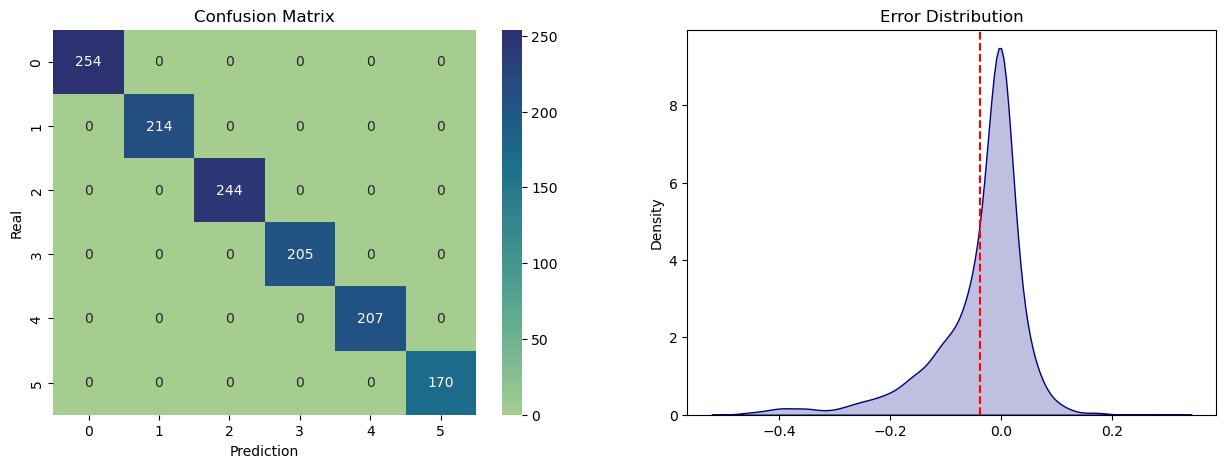

In [180]:
logits_train = torch.tensor([]).to(device)
X_train_tensor = torch.load('data/train/X_train_data.pt')
y_train_tensor = torch.load('data/train/y_train_data.pt')

Train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(Train_dataset, batch_size=256, shuffle=False)

for x_batch, y_batch in train_loader:
    with torch.inference_mode():
        logits = Model(x_batch.to(device))
        logits_train = torch.cat((logits_train, logits), dim=0)

evaluate_model(y_eval=y_train_tensor, logits_pred=logits_train)
del X_train_tensor, y_train_tensor 
torch.cuda.empty_cache()